# Detecting Climate Disinformation based on text from news articles : Explore the Data 

## Import Python Packages

In [1]:
from datetime import datetime
from pprint import pprint

from datasets import (load_dataset_builder,
                      load_dataset,
                      get_dataset_split_names)


import evaluate

from fastapi import APIRouter

import matplotlib.pyplot as plt
plt.style.use('ggplot')

import numpy as np


import pandas as pd

from tqdm import tqdm

from utils.evaluation import TextEvaluationRequest
from utils.emissions import tracker, clean_emissions_data, get_space_info

print('All packages imported successfully!')

[codecarbon WARNING @ 20:09:17] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 20:09:17] [setup] RAM Tracking...
[codecarbon INFO @ 20:09:17] [setup] CPU Tracking...
[codecarbon WARNING @ 20:09:17] No CPU tracking mode found. Falling back on CPU constant mode. 
 Linux OS detected: Please ensure RAPL files exist at \sys\class\powercap\intel-rapl to measure CPU

[codecarbon WARNING @ 20:09:18] We saw that you have a Intel(R) Xeon(R) Platinum 8370C CPU @ 2.80GHz but we don't know it. Please contact us.
[codecarbon INFO @ 20:09:18] CPU Model on constant consumption mode: Intel(R) Xeon(R) Platinum 8370C CPU @ 2.80GHz
[codecarbon INFO @ 20:09:18] [setup] GPU Tracking...
[codecarbon INFO @ 20:09:18] No GPU found.
[codecarbon INFO @ 20:09:18] >>> Tracker's metadata:
[codecarbon INFO @ 20:09:18]   Platform system: Linux-6.5.0-1025-azure-x86_64-with-glibc2.31
[codecarbon INFO @ 20:09:18]   Python version: 3.12.1
[codecarbon INFO @ 20:09:18]   CodeCarbon 

All packages imported successfully!


## Explore the Dataset

In [41]:
ds_builder = load_dataset_builder("QuotaClimat/frugalaichallenge-text-train", split=["train"])

ValueError: BuilderConfig ParquetConfig(name='default', version=0.0.0, data_dir=None, data_files={'train': ['data/train-*'], 'test': ['data/test-*']}, description=None, batch_size=None, columns=None, features=None, filters=None) doesn't have a 'split' key.

In [3]:
# Inspect the number of splits available for the dataset

get_dataset_split_names("QuotaClimat/frugalaichallenge-text-train")

['train', 'test']

In [4]:
# Inspect dataset features

ds_builder.info.features

{'quote': Value(dtype='string', id=None),
 'label': Value(dtype='string', id=None),
 'source': Value(dtype='string', id=None),
 'url': Value(dtype='string', id=None),
 'language': Value(dtype='string', id=None),
 'subsource': Value(dtype='string', id=None),
 'id': Value(dtype='null', id=None),
 '__index_level_0__': Value(dtype='int64', id=None)}

In [36]:
# Download the dataset 

dataset = load_dataset("QuotaClimat/frugalaichallenge-text-train")

In [37]:
print(f"ROWS: {dataset.num_rows}")
print(f"COLUMNS: {dataset.num_columns}")

ROWS: {'train': 4872, 'test': 1219}
COLUMNS: {'train': 8, 'test': 8}


In [38]:
print(f"COLUMN NAMES: {dataset.column_names}")

COLUMN NAMES: {'train': ['quote', 'label', 'source', 'url', 'language', 'subsource', 'id', '__index_level_0__'], 'test': ['quote', 'label', 'source', 'url', 'language', 'subsource', 'id', '__index_level_0__']}


In [39]:
# EXAMPLE ROW
pprint(dataset[0])

KeyError: "Invalid key: 0. Please first select a split. For example: `my_dataset_dictionary['train'][0]`. Available splits: ['test', 'train']"

In [9]:
# Get unique values from the 'language' column
dataset.unique('language')

['en']

In [10]:
# Get the count of unique URLs
len(dataset.unique('url'))

745

In [11]:
# Get unique values from the 'source' column
dataset.unique('source')

['FLICC', 'Desmog']

In [12]:
# Get unique values from the 'subsource' column
dataset.unique('subsource')

['CARDS',
 'hamburg_test3',
 None,
 'jindev',
 'jintrain',
 'hamburg_test2',
 'Alhindi_train',
 'hamburg_test1',
 'jintest',
 'Alhindi_test',
 'Alhindi_dev']

In [13]:
# Get the count of unique quotes
len(dataset.unique('quote'))

4872

In [14]:
# Get unique values from the 'label' column
dataset.unique('label')

['0_not_relevant',
 '6_proponents_biased',
 '3_not_bad',
 '2_not_human',
 '1_not_happening',
 '4_solutions_harmful_unnecessary',
 '5_science_unreliable',
 '7_fossil_fuels_needed']

In [15]:
# Get unique values from the 'id' column
dataset.unique('id')

[None]

In [16]:
# Get the count of unique index values.
len(dataset.unique('__index_level_0__'))

4872

In [17]:
single_l = dataset['label'][0]
print(single_l)

0_not_relevant


In [18]:
x, y =single_l.split('_', maxsplit=1)

In [19]:
z = int(x)

In [20]:
y

'not_relevant'

In [21]:
type(z), type(y)

(int, str)

In [22]:
LABEL_MAPPING = {
    "0_not_relevant": 0,
    "1_not_happening": 1,
    "2_not_human": 2,
    "3_not_bad": 3,
    "4_solutions_harmful_unnecessary": 4,
    "5_science_unreliable": 5,
    "6_proponents_biased": 6,
    "7_fossil_fuels_needed": 7
}

We would like to understand some properties of the data. As a start, let's analyze the lengths of different sentences in the  `quote` column. 
We will make a histogram of the number of words in each quote over the full corpus.

In [23]:
def make_histogram(dataset):
  
  num_tokens = []  # each sentence should add an integer to this list.

  # Make a histogram of the lengths of sentences in the dataset.
  pbar = tqdm(total=len(dataset), leave=True, position=0)
  for entry in dataset:
    tokens = entry['quote'].split()
    num_tokens.append(len(tokens))
    pbar.update()
  pbar.close()

  plt.figure()
  plt.hist(num_tokens, bins=1000)
  plt.xlabel('Number of tokens')
  plt.xlim(0, 1000)
  plt.show()
  return num_tokens

100%|██████████| 4872/4872 [00:00<00:00, 14747.66it/s]


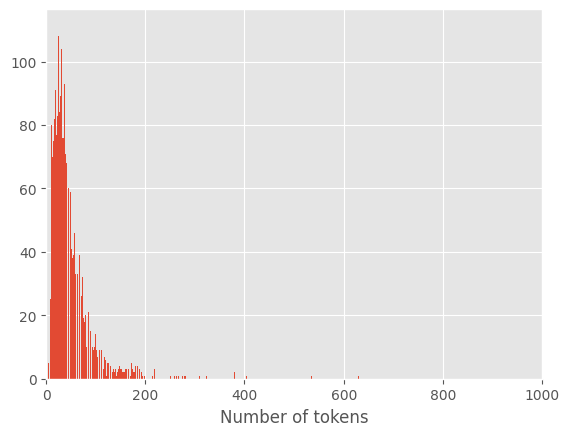

In [24]:
num_tokens = make_histogram(dataset)

In [25]:
# Q: How many words is the shortest quote and how many quotes have that length?

from collections import Counter

token_counter = Counter(num_tokens)
shortest = min(num_tokens)
longest = max(num_tokens)

num_shortest = token_counter[shortest]
num_longest = token_counter[longest]

print(f'{num_shortest} quotes have {shortest} tokens.')
print(f'{num_longest} quotes has {longest} tokens.')

1 quotes have 3 tokens.
1 quotes has 789 tokens.


In [26]:
# print out the shortest entry
for entry in dataset:
  if len(entry['quote'].split()) == shortest:
    pprint(entry)

{'__index_level_0__': 277,
 'id': None,
 'label': '3_not_bad',
 'language': 'en',
 'quote': 'reefs are improving',
 'source': 'FLICC',
 'subsource': 'hamburg_test3',
 'url': 'https://huggingface.co/datasets/fzanartu/FLICCdataset'}


In [28]:
# print out the longest entry

max_tokens = 0
longest_quote = None

for entry in dataset:
    tokens = entry['quote'].split()
    if len(tokens) > max_tokens:
        longest_quote = entry['quote']
        max_tokens = len(tokens)

In [29]:
pprint(longest_quote)

('Hubris is a Greek word that means dangerously overconfident. Based on my '
 'research, hubris fairly describes our current response to the issue of '
 'climate change Here’s what many people believe One: The planet is warming '
 'catastrophically because of certain human behaviors Two: Thanks to powerful '
 'computers we can project what the climate will be like 20, 40, or even 100 '
 'years from now Three: That if we eliminate just one behavior, the burning of '
 'fossil fuels, we can prevent the climate from changing for as long we like '
 'Each of these presumptions—together, the basis of our hubris regarding the '
 'changing climate—is either untrue or so far off the mark as to be useless '
 'Yes, it’s true that the globe is warming, and that humans are exerting a '
 'warming influence upon it. But beyond that, to paraphrase a line from the '
 'classic movie The Princess Bride, ‘I do not think “The Science” says what '
 'you think it says. For example, government reports state cl

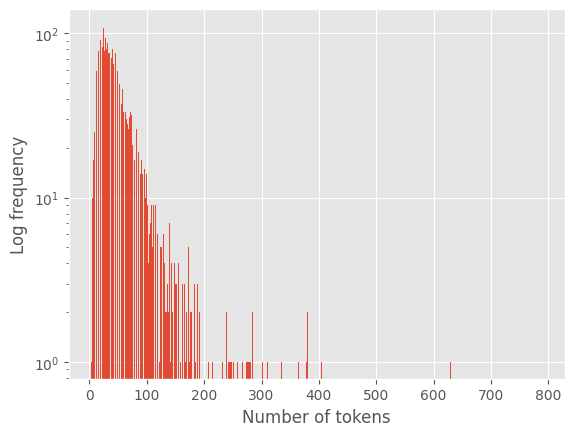

In [30]:
# Re-plot the histogram in log frequency space.
plt.figure()
plt.hist(num_tokens, bins=1000, log=True)
plt.xlabel('Number of tokens')
plt.ylabel('Log frequency')
plt.show()

### Vocabulary Analysis

100%|██████████| 4872/4872 [00:00<00:00, 8373.09it/s] 


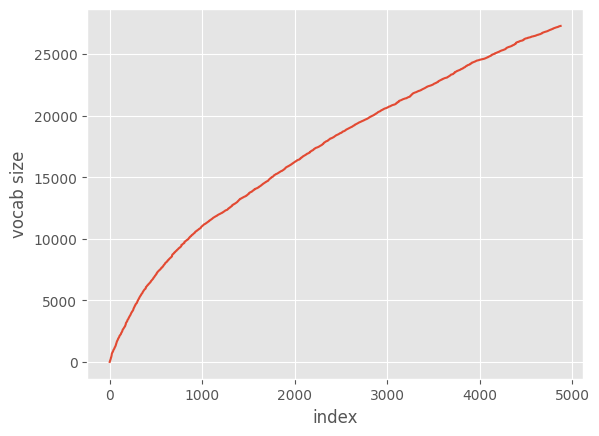

In [31]:
from collections import defaultdict

vocab = defaultdict(lambda: 0)
# after 0 sentences, vocab size is at 0.
vocab_sizes = [0]

# Plot the vocabulary against the number of sentences.
for i in tqdm(range(len(dataset)), leave=True, position=0):
  entry = dataset[i]
  tokens = entry['quote'].split()
  for token in tokens:
    vocab[token] += 1
  vocab_sizes.append(len(vocab))

plt.figure()
plt.plot(vocab_sizes)
plt.xlabel('index')
plt.ylabel('vocab size')
plt.show()

* How big is the vocabulary size?
* How big is the vocabulary for words appearing more than once?
* How big is the vocabulary for words appearing more than three times?

In [32]:
print(f'{len(vocab)} words in vocab.')
print(f'{len([k for k in vocab if vocab[k] > 1])} words appearing > 1 times.')
print(f'{len([k for k in vocab if vocab[k] > 3])} words appearing > 3 times.')

27278 words in vocab.
12091 words appearing > 1 times.
6039 words appearing > 3 times.


Looks like vocabulary continues to grow as a function of the dataset size. There are more than 30k unique words in the vocabulary!

In [33]:
most_frequent = []
least_frequent = []

# Print the most frequent 100 words, and the least frequent 100 words.
words = np.array(list(vocab.keys()))
counts = np.array([vocab[w] for w in words])
words_ordered = words[np.argsort(counts)[::-1]]
most_frequent = words_ordered[:111]
least_frequent = words_ordered[-100:]

print('Most frequent:')
print(most_frequent)
print()
print('Least frequent:')
print(least_frequent)

Most frequent:
['the' 'of' 'to' 'and' 'is' 'a' 'that' 'in' 'climate' 'for' 'are' 'on'
 'not' 'have' 'it' 'be' 'The' 'I' 'as' 'we' 'by' 'has' 'with' 'global'
 'will' 'this' 'change' 'from' 'warming' 'about' 'or' 'you' 'more' 'they'
 'our' 'an' 'been' 'at' 'no' 'than' 'was' 'all' 'carbon' 'but' 'would'
 'their' 'energy' 'there' 'do' 'CO2' 'can' 'what' 'We' 'which' 'who'
 'people' 'It' 'so' 'think' 'if' 'one' 'And' 'years' 'should' 'because'
 'temperature' 'other' 'dioxide' 'these' 'over' 'going' 'any' 'only' 'its'
 'it’s' 'even' 'emissions' '–' 'out' 'science' 'like' 'Climate' 'just'
 'much' 'In' 'This' 'very' 'don’t' 'when' 'gas' 'some' 'natural' '[…]'
 'most' 'were' 'But' 'human' 'scientific' 'also' 'how' 'up' 'he'
 'greenhouse' 'many' 'If' 'make' 'into' 'There' 'world' 'environmental'
 'need']

Least frequent:
['unnoticed' 'Valley,' '134' '1922.' 'INEOS’' 'contrasts' 'panel,'
 'state-of-the-art' 'whacked' 'Rush' 'Waxman,' 'Henry' 'conceit.' 'finest'
 'booklet,' 'emotion.' 'madness,' '

### Data Balancing

In [34]:
from collections import Counter

labels = [entry['label'] for entry in dataset]
labels = Counter(labels)
pprint(labels)

Counter({'0_not_relevant': 1311,
         '6_proponents_biased': 643,
         '5_science_unreliable': 641,
         '4_solutions_harmful_unnecessary': 614,
         '1_not_happening': 587,
         '2_not_human': 565,
         '3_not_bad': 289,
         '7_fossil_fuels_needed': 222})


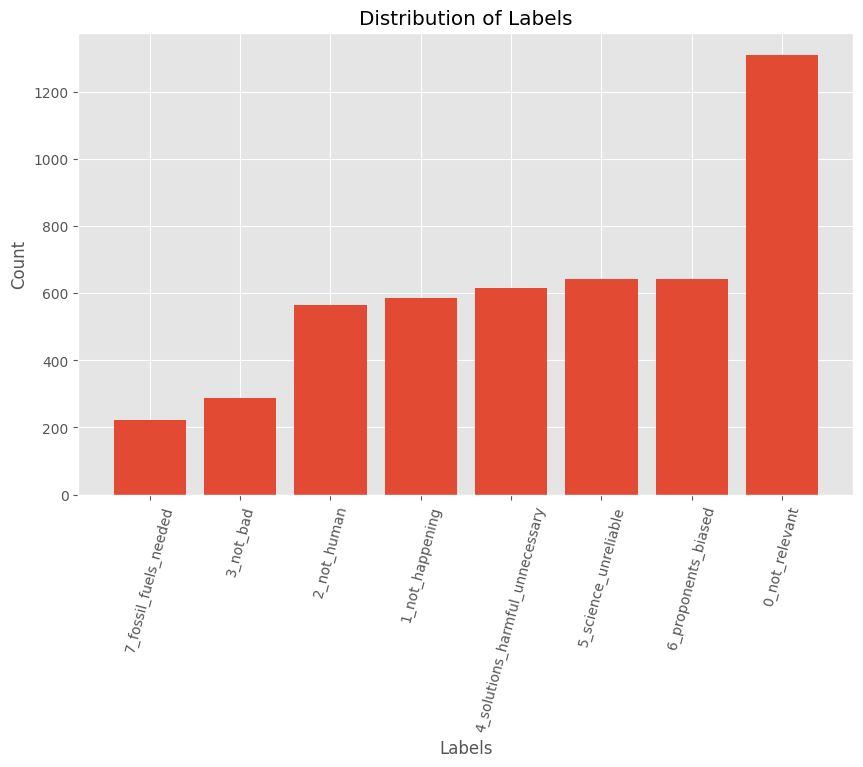

In [35]:
# Sort the labels by their count
sorted_labels = dict(sorted(labels.items(), key=lambda item: item[1]))

plt.figure(figsize=(10, 6))
plt.bar(sorted_labels.keys(), sorted_labels.values())
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Distribution of Labels')
plt.xticks(rotation=75)
plt.show()

The imbalance jumps out. There is a lot of `0_not_relevant` quotes than anything else. Since there is a lot of general discussion in the media other than climate topics, it makes sense.

## MODELS

In [66]:
MODELS = []



## Evaluation Metrics

In [67]:
clf_metrics = evaluate.combine(["accuracy", "f1", "precision", "recall"])

In [68]:
accuracy = evaluate.load("accuracy")

In [69]:
pprint(accuracy.description)

('\n'
 'Accuracy is the proportion of correct predictions among the total number of '
 'cases processed. It can be computed with:\n'
 'Accuracy = (TP + TN) / (TP + TN + FP + FN)\n'
 ' Where:\n'
 'TP: True positive\n'
 'TN: True negative\n'
 'FP: False positive\n'
 'FN: False negative\n')


In [70]:
accuracy.features

{'predictions': Value(dtype='int32', id=None),
 'references': Value(dtype='int32', id=None)}